In [1]:
import sys
sys.path.append('../')

In [20]:
import torch
import glob
from utils.datasets.RawStreamData import RawStreamDS
from utils.functions_SX import get_ideal_basis, print_solution
import torch
import numpy as np

from tqdm import tqdm
from torch.utils.data import DataLoader, Subset, ConcatDataset
from models.indexer_model import ToroIndexer

import lovely_tensors as lt

lt.monkey_patch()

import os

cwd = os.getcwd()

streams_path = cwd+"/../data/lyso_12p4kev_1khz_150mm_run000026"
# streams_path = cwd+"/../data/performance_test"
mylist = glob.glob(streams_path + '/*.stream', recursive=True)
path = mylist[0]

mds = RawStreamDS(path, sequence_length=200, no_padding=True)

Creating DS from  /Users/lfbarba/GitHub/toro-indexer-for-serial-crystallography/notebooks/../data/lyso_12p4kev_1khz_150mm_run000026/Lyso_12p4keV_1kHz_150mm_run000026_data_000001.th6.snr4.0.mpixco1.stream


# Visualize results from stream_file_indexer.py

To generate the solution files, run first *python stream_file_indexer.py*

In [17]:
indices = np.load("../solution_indices.npy")
bases = np.load("../solution_matrices.npy")

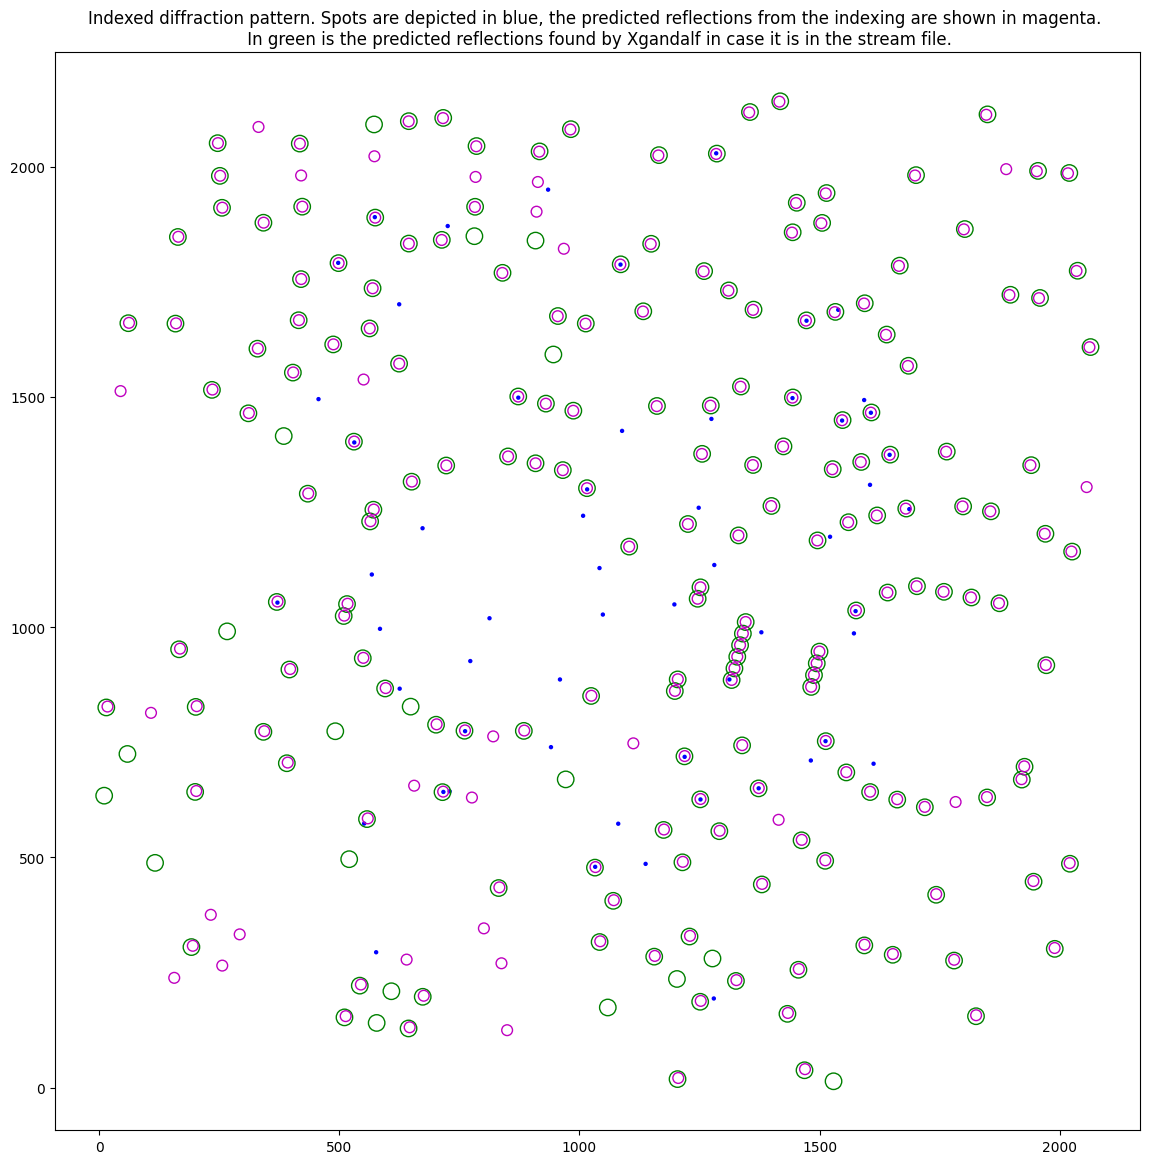

In [18]:
import random
idx = random.randint(0, len(indices) - 1)
mds_idx = indices[idx]
cell_parameters = mds.instances[mds_idx]['initial_cell']
initial_cell = get_ideal_basis(cell_parameters)
print_solution(torch.FloatTensor(bases[idx]), mds_idx, mds, initial_cell)